In [1]:
import os
import math
import numbers
import random
import torchvision.transforms.functional as tf

from PIL import Image, ImageOps


class Compose(object):
    def __init__(self, augmentations):
        self.augmentations = augmentations
        self.PIL2Numpy = False

    def __call__(self, img, mask):
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img, mode="RGB")
            mask = Image.fromarray(mask, mode="RGB")
            self.PIL2Numpy = True

        assert img.size == mask.size
        for a in self.augmentations:
            img, mask = a(img, mask)

        if self.PIL2Numpy:
            img, mask = np.array(img), np.array(mask, dtype=np.uint8)

        return img, mask

class RandomHorizontallyFlip(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, img, mask):
        if random.random() < self.p:
            return (img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT))
        return img, mask
        
class RandomCrop(object):
    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    def __call__(self, img, mask):
        if self.padding > 0:
            img = ImageOps.expand(img, border=self.padding, fill=0)
            mask = ImageOps.expand(mask, border=self.padding, fill=0)

        assert img.size == mask.size
        w, h = img.size
        ch, cw = self.size
        if w == cw and h == ch:
            return img, mask
        if w < cw or h < ch:
            pw = cw - w if cw > w else 0
            ph = ch - h if ch > h else 0
            padding = (pw,ph,pw,ph)
            img  = ImageOps.expand(img,  padding, fill=0)
            mask = ImageOps.expand(mask, padding, fill=250)
            w, h = img.size
            assert img.size == mask.size
            
        x1 = random.randint(0, w - cw)
        y1 = random.randint(0, h - ch)
        return (img.crop((x1, y1, x1 + cw, y1 + ch)), mask.crop((x1, y1, x1 + cw, y1 + ch)))


In [2]:
from traitlets.traitlets import Long
#data loader
import collections
import torch
import numpy as np
import scipy.misc as m
import matplotlib.pyplot as plt
import skimage.transform
from torch.utils import data


def rgb_to_lbl(rgb, size):
    Sky = [128, 128, 128]
    Building = [128, 0, 0]
    Pole = [192, 192, 128]
    Road = [128, 64, 128]
    Pavement = [60, 40, 222]
    Tree = [128, 128, 0]
    SignSymbol = [192, 128, 128]
    Fence = [64, 64, 128]
    Car = [64, 0, 128]
    Pedestrian = [64, 64, 0]
    Bicyclist = [0, 128, 192]
#     Unlabelled = [0, 0, 0]

    label_colours = np.array(
        [
            Sky,
            Building,
            Pole,
            Road,
            Pavement,
            Tree,
            SignSymbol,
            Fence,
            Car,
            Pedestrian,
            Bicyclist,
#             Unlabelled,
        ]
    )
    label = 11 * torch.ones(size[0] * size[1], dtype=torch.uint8)
    w, h, t = rgb.size()
    rgb = rgb.reshape(-1, t)
    for l in range(0, len(label_colours)):
      r = rgb[:, 0] == label_colours[l, 0]
      g = rgb[:, 1] == label_colours[l, 1]
      b = rgb[:, 2] == label_colours[l, 2]
      tf_rgb = r * g * b
      label[tf_rgb] = l
    label = label.reshape(size[0], size[1])
    #print(rgb2[360][260:270], label[360][260:270])
    return label

class camvidLoader(data.Dataset):
    def __init__(
        self,
        root,
        split="train",
        is_transform=False,
        img_size=None,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.split = split
        self.img_size = img_size if img_size is not None else [360, 480];
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.n_classes = 11
        self.files = collections.defaultdict(list)

        if not self.test_mode:
            for split in ["train", "test", "val"]:
                file_list = os.listdir(root + "/" + split)
                self.files[split] = file_list

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        img_name = self.files[self.split][index]
        img_path = self.root + "/" + self.split + "/" + img_name
        lbl_path = self.root + "/" + self.split + "_labels/" + img_name.split('.')[0] + '_L.' + img_name.split('.')[1]

        img = plt.imread(img_path)
        img = np.array(img*255, dtype=np.uint8)

        lbl = plt.imread(lbl_path)
        lbl = np.array(lbl*255, dtype=np.uint8)

        if self.augmentations is not None:
            img, lbl = self.augmentations(img, lbl)

        if self.is_transform:
            img, lbl = self.transform(img, lbl)
        return img, lbl

    def transform(self, img, lbl):
#         print(img.shape, lbl.shape)
        img = skimage.transform.resize(img, (self.img_size[0], self.img_size[1]), preserve_range=True)  # uint8 with RGB mode
        lbl = skimage.transform.resize(lbl, (self.img_size[0], self.img_size[1]), anti_aliasing=False, preserve_range=True)
#         print(img.shape, lbl.shape)
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean
        if self.img_norm:
            # Resize scales images from 0 to 255, thus we need
            # to divide by 255.0
            img = img.astype(float) / 255.0
        # NHWC -> NCHW
        img = img.transpose(2, 0, 1)

        img = torch.from_numpy(img).float()
        return img, lbl

    def decode_segmap(self, temp, plot=False):
        Sky = [128, 128, 128]
        Building = [128, 0, 0]
        Pole = [192, 192, 128]
        Road = [128, 64, 128]
        Pavement = [60, 40, 222]
        Tree = [128, 128, 0]
        SignSymbol = [192, 128, 128]
        Fence = [64, 64, 128]
        Car = [64, 0, 128]
        Pedestrian = [64, 64, 0]
        Bicyclist = [0, 128, 192]
        # Unlabelled = [0, 0, 0]

        label_colours = np.array(
            [
                Sky,
                Building,
                Pole,
                Road,
                Pavement,
                Tree,
                SignSymbol,
                Fence,
                Car,
                Pedestrian,
                Bicyclist,
                # Unlabelled,
            ]
        )
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = label_colours[l, 0]
            g[temp == l] = label_colours[l, 1]
            b[temp == l] = label_colours[l, 2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

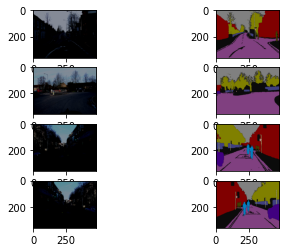

 ex


In [3]:
#testing data loader
local_path = "../input/camvid/CamVid"
augmentations = Compose([RandomHorizontallyFlip(0.5), 
                         #RandomCrop(270, 360)
                         ])

dst = camvidLoader(local_path, is_transform=True, augmentations=augmentations)
bs = 4
trainloader = data.DataLoader(dst, batch_size=bs, shuffle=True)
for i, data_samples in enumerate(trainloader):
    imgs, labels = data_samples
    # print(imgs.size())
    imgs = imgs.numpy()[:, ::-1, :, :]
    imgs = np.transpose(imgs, [0, 2, 3, 1])
    newlabels=torch.zeros((labels.shape[0], labels.shape[1], labels.shape[2]))
    # print(type(labels))
    for i in range(len(labels)):
      #print(labels[i,:,:,:].shape)
      # print(labels[i, :, :, :].size(), imgs.shape)
      newlabels[i] = rgb_to_lbl(labels[i,:,:,:], [labels.shape[1], labels.shape[2]])
    labels = newlabels
    f, axarr = plt.subplots(bs, 2)
    for j in range(bs):
        axarr[j][0].imshow(imgs[j])
        axarr[j][1].imshow(dst.decode_segmap(newlabels.numpy()[j]))
    plt.show()
    a = input()
    if a == "ex":
        break
    else:
        plt.close()

In [4]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import collections
#from CatConv2d.catconv2d import CatConv2d

class ConvLayer(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel=3, stride=1, dropout=0.1):
        super().__init__()
        self.add_module('conv', nn.Conv2d(in_channels, out_channels, kernel_size=kernel,
                                          stride=stride, padding=kernel//2, bias = False))
        self.add_module('norm', nn.BatchNorm2d(out_channels))
        self.add_module('relu', nn.ReLU(inplace=True))

        #print(kernel, 'x', kernel, 'x', in_channels, 'x', out_channels)

    def forward(self, x):
        return super().forward(x)
        

class BRLayer(nn.Sequential):
    def __init__(self, in_channels):
        super().__init__()
        
        self.add_module('norm', nn.BatchNorm2d(in_channels))
        self.add_module('relu', nn.ReLU(True))
    def forward(self, x):
        return super().forward(x)


class HarDBlock_v2(nn.Module):
    def get_link(self, layer, base_ch, growth_rate, grmul):
        if layer == 0:
          return base_ch, 0, []
        out_channels = growth_rate
        link = []
        for i in range(10):
          dv = 2 ** i
          if layer % dv == 0:
            k = layer - dv
            link.append(k)
            if i > 0:
                out_channels *= grmul
        out_channels = int(int(out_channels + 1) / 2) * 2
        in_channels = 0
        for i in link:
          ch,_,_ = self.get_link(i, base_ch, growth_rate, grmul)
          in_channels += ch
        return out_channels, in_channels, link


    def get_out_ch(self):
        return self.out_channels

    def __init__(self, in_channels, growth_rate, grmul, n_layers, keepBase=False, residual_out=False, dwconv=False, list_out=False):
        super().__init__()
        self.in_channels = in_channels
        self.growth_rate = growth_rate
        self.grmul = grmul
        self.n_layers = n_layers
        self.keepBase = keepBase
        self.links = []
        self.list_out = list_out
        layers_ = []
        self.out_channels = 0

        for i in range(n_layers):
          outch, inch, link = self.get_link(i+1, in_channels, growth_rate, grmul)
          self.links.append(link)
          use_relu = residual_out
          #layers_.append(CatConv2d(inch, outch, (3,3), relu=True))
          layers_.append(nn.Conv2d(inch, outch, (3,3), relu=True))

          if (i % 2 == 0) or (i == n_layers - 1):
            self.out_channels += outch
        print("Blk out =",self.out_channels)
        self.layers = nn.ModuleList(layers_)

    def transform(self, blk):
        for i in range(len(self.layers)):
            self.layers[i].weight[:,:,:,:] = blk.layers[i][0].weight[:,:,:,:]
            self.layers[i].bias[:] = blk.layers[i][0].bias[:]

    def forward(self, x):
        layers_ = [x]
        #self.res = []
        for layer in range(len(self.layers)):
            link = self.links[layer]
            tin = []
            for i in link:
                tin.append(layers_[i])

            out = self.layers[layer](tin)
            #self.res.append(out)
            layers_.append(out)
        t = len(layers_)
        out_ = []
        for i in range(t):
          if (i == 0 and self.keepBase) or \
             (i == t-1) or (i%2 == 1):
              out_.append(layers_[i])
        if self.list_out:
            return out_
        else:
            return torch.cat(out_, 1)



class HarDBlock(nn.Module):
    def get_link(self, layer, base_ch, growth_rate, grmul):
        if layer == 0:
          return base_ch, 0, []
        out_channels = growth_rate
        link = []
        for i in range(10):
          dv = 2 ** i
          if layer % dv == 0:
            k = layer - dv
            link.append(k)
            if i > 0:
                out_channels *= grmul
        out_channels = int(int(out_channels + 1) / 2) * 2
        in_channels = 0
        for i in link:
          ch,_,_ = self.get_link(i, base_ch, growth_rate, grmul)
          in_channels += ch
        return out_channels, in_channels, link

    def get_out_ch(self):
        return self.out_channels
 
    def __init__(self, in_channels, growth_rate, grmul, n_layers, keepBase=False, residual_out=False):
        super().__init__()
        self.in_channels = in_channels
        self.growth_rate = growth_rate
        self.grmul = grmul
        self.n_layers = n_layers
        self.keepBase = keepBase
        self.links = []
        layers_ = []
        self.out_channels = 0 # if upsample else in_channels
        for i in range(n_layers):
          outch, inch, link = self.get_link(i+1, in_channels, growth_rate, grmul)
          self.links.append(link)
          use_relu = residual_out
          layers_.append(ConvLayer(inch, outch))
          if (i % 2 == 0) or (i == n_layers - 1):
            self.out_channels += outch
        #print("Blk out =",self.out_channels)
        self.layers = nn.ModuleList(layers_)


    def forward(self, x):
        layers_ = [x]
        for layer in range(len(self.layers)):
            link = self.links[layer]
            tin = []
            for i in link:
                tin.append(layers_[i])
            if len(tin) > 1:
                x = torch.cat(tin, 1)
            else:
                x = tin[0]
            out = self.layers[layer](x)
            layers_.append(out)
        t = len(layers_)
        out_ = []
        for i in range(t):
          if (i == 0 and self.keepBase) or \
             (i == t-1) or (i%2 == 1):
              out_.append(layers_[i])
        out = torch.cat(out_, 1)
        return out



class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        #print("upsample",in_channels, out_channels)

    def forward(self, x, skip, concat=True):
        is_v2 = type(skip) is list
        if is_v2:
            skip_x = skip[0]
        else:
            skip_x = skip
        out = F.interpolate(
                x,
                size=(skip_x.size(2), skip_x.size(3)),
                mode="bilinear",
                align_corners=True,
                            )
        if concat:       
          if is_v2:
            out = [out] + skip
          else:                     
            out = torch.cat([out, skip], 1)
          
        return out

class hardnet(nn.Module):
    def __init__(self, n_classes=11):
        super(hardnet, self).__init__()

        first_ch  = [16,24,32,48]
        ch_list = [  64, 96, 160, 224, 320]
        grmul = 1.7
        gr       = [  10,16,18,24,32]
        n_layers = [   4, 4, 8, 8, 8]

        blks = len(n_layers) 
        self.shortcut_layers = []

        self.base = nn.ModuleList([])
        self.base.append (
             ConvLayer(in_channels=3, out_channels=first_ch[0], kernel=3,
                       stride=2) )
        self.base.append ( ConvLayer(first_ch[0], first_ch[1],  kernel=3) )
        self.base.append ( ConvLayer(first_ch[1], first_ch[2],  kernel=3, stride=2) )
        self.base.append ( ConvLayer(first_ch[2], first_ch[3],  kernel=3) )

        skip_connection_channel_counts = []
        ch = first_ch[3]
        for i in range(blks):
            blk = HarDBlock(ch, gr[i], grmul, n_layers[i])
            ch = blk.get_out_ch()
            skip_connection_channel_counts.append(ch)
            self.base.append ( blk )
            if i < blks-1:
              self.shortcut_layers.append(len(self.base)-1)

            self.base.append ( ConvLayer(ch, ch_list[i], kernel=1) )
            ch = ch_list[i]
            
            if i < blks-1:            
              self.base.append ( nn.AvgPool2d(kernel_size=2, stride=2) )


        cur_channels_count = ch
        prev_block_channels = ch
        n_blocks = blks-1
        self.n_blocks =  n_blocks

        # upsampling

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        self.conv1x1_up    = nn.ModuleList([])
        
        for i in range(n_blocks-1,-1,-1):
            self.transUpBlocks.append(TransitionUp(prev_block_channels, prev_block_channels))
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]
            self.conv1x1_up.append(ConvLayer(cur_channels_count, cur_channels_count//2, kernel=1))
            cur_channels_count = cur_channels_count//2

            blk = HarDBlock(cur_channels_count, gr[i], grmul, n_layers[i])
            
            self.denseBlocksUp.append(blk)
            prev_block_channels = blk.get_out_ch()
            cur_channels_count = prev_block_channels


        self.finalConv = nn.Conv2d(in_channels=cur_channels_count,
               out_channels=n_classes, kernel_size=1, stride=1,
               padding=0, bias=True)
    
    def v2_transform(self):        
        for i in range( len(self.base)):
            if isinstance(self.base[i], HarDBlock):
                blk = self.base[i]
                self.base[i] = HarDBlock_v2(blk.in_channels, blk.growth_rate, blk.grmul, blk.n_layers, list_out=True)
                self.base[i].transform(blk)
            elif isinstance(self.base[i], nn.Sequential):
                blk = self.base[i]
                sz = blk[0].weight.shape
                if sz[2] == 1:
                    #self.base[i] = CatConv2d(sz[1],sz[0],(1,1), relu=True)
                    self.base[i] = nn.Conv2d(sz[1],sz[0],(1,1), relu=True)
                    self.base[i].weight[:,:,:,:] = blk[0].weight[:,:,:,:]
                    self.base[i].bias[:] = blk[0].bias[:]

        for i in range(self.n_blocks):
            blk = self.denseBlocksUp[i]
            self.denseBlocksUp[i] = HarDBlock_v2(blk.in_channels, blk.growth_rate, blk.grmul, blk.n_layers, list_out=False)
            self.denseBlocksUp[i].transform(blk)
  
        for i in range(len(self.conv1x1_up)):
            blk = self.conv1x1_up[i]
            sz = blk[0].weight.shape
            if sz[2] == 1:
                #self.conv1x1_up[i] = CatConv2d(sz[1],sz[0],(1,1), relu=True)
                self.conv1x1_up[i] = nn.Conv2d(sz[1],sz[0],(1,1), relu=True)
                self.conv1x1_up[i].weight[:,:,:,:] = blk[0].weight[:,:,:,:]
                self.conv1x1_up[i].bias[:] = blk[0].bias[:]                 

    def forward(self, x):
        
        skip_connections = []
        size_in = x.size()
        
        
        for i in range(len(self.base)):
            x = self.base[i](x)
            if i in self.shortcut_layers:
                skip_connections.append(x)
        out = x
        
        for i in range(self.n_blocks):
            skip = skip_connections.pop()
            out = self.transUpBlocks[i](out, skip, True)
            out = self.conv1x1_up[i](out)
            out = self.denseBlocksUp[i](out)
        
        out = self.finalConv(out)
        
        out = F.interpolate(
                            out,
                            size=(size_in[2], size_in[3]),
                            mode="bilinear",
                            align_corners=True)
        return out

In [5]:
class runningScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask], minlength=n_class ** 2
        ).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        """Returns accuracy score evaluation result.
            - overall accuracy
            - mean accuracy
            - mean IU
            - fwavacc
        """
        hist = self.confusion_matrix
        acc = np.diag(hist).sum() / hist.sum()
        acc_cls = np.diag(hist) / hist.sum(axis=1)
        acc_cls = np.nanmean(acc_cls)
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
        mean_iu = np.nanmean(iu)
        freq = hist.sum(axis=1) / hist.sum()
        fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
        cls_iu = dict(zip(range(self.n_classes), iu))

        return (
            {
                "Overall Acc: \t": acc,
                "Mean Acc : \t": acc_cls,
                "FreqW Acc : \t": fwavacc,
                "Mean IoU : \t": mean_iu,
            },
            cls_iu,
        )

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))


class averageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [6]:
def cross_entropy2d(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()
    #print(input.size(), target.size())
    #nt, ht, wt = target.size()

    if h != ht and w != wt:  # upsample labels
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    #print(input.size(), target.size())
    #print(input[0, 0].dtype, target[0].dtype)
    loss = F.cross_entropy(
              input, target, weight=weight, size_average=size_average, ignore_index=11, reduction='mean')

    return loss


In [12]:
import time
from tqdm import tqdm

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)


# Setup seeds
torch.manual_seed(1337)
torch.cuda.manual_seed(1337)
np.random.seed(1337)
random.seed(1337)

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup Augmentations
data_aug = Compose([RandomHorizontallyFlip(0.5), 
                    # RandomCrop((270, 360))
                    ])

# Setup Dataloader

data_loader = camvidLoader
data_path = '../input/camvid/CamVid'

t_loader = data_loader(
    data_path,
    is_transform=True,
    split='train',
    img_size=(720, 960),
    augmentations=data_aug,
)

v_loader = data_loader(
    data_path,
    is_transform=True,
    split='val',
    img_size=(720, 960),
)

n_classes = t_loader.n_classes
trainloader = data.DataLoader(
    t_loader,
    batch_size=16,
    shuffle=True,
)

valloader = data.DataLoader(
    v_loader, 
    batch_size=16, 
)

# Setup Metrics
running_metrics_val = runningScore(n_classes)

# Setup Model

model = hardnet()

total_params = sum(p.numel() for p in model.parameters())
print( 'Parameters:',total_params )

model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model.apply(weights_init)
optimizer_cls = torch.optim.Adam

optimizer = optimizer_cls(model.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=2.5e-5)
print("Using optimizer {}".format(optimizer))

num_epochs = 80
per_epoch = len(trainloader)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

loss_fn = cross_entropy2d
print("Using loss {}".format(loss_fn))

start_epoch = 0
resume = True
file_checkpoint = './hardnet_CamVid_checkpoint.pkl'
if resume is not None:
    if os.path.isfile(file_checkpoint):
        print("Loading model and optimizer from checkpoint '{}'".format(file_checkpoint))
              
        checkpoint = torch.load(file_checkpoint)
        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        scheduler.load_state_dict(checkpoint["scheduler_state"])
        start_epoch = checkpoint["epoch"] + 1

    else:
        print("No checkpoint found at '{}'".format(file_checkpoint))

val_loss_meter = averageMeter()
time_meter = averageMeter()

best_iou = -100.0
flag = True
loss_all = 0
loss_n = 0
for epoch in range(start_epoch, num_epochs):
    curr_iter = 0
    for (images, labels) in trainloader:
        start_ts = time.time()
        curr_iter += 1
        model.train()
        images = images.to(device)
        newlabels = torch.zeros((labels.shape[0], labels.shape[1], labels.shape[2]))
        for j in range(len(labels)):
          newlabels[j] = rgb_to_lbl(labels[j, :, :, :], [labels.shape[1], labels.shape[2]])
        labels = newlabels
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = loss_fn(input=outputs, target=labels.long())
        loss.backward()
        optimizer.step()
        c_lr = scheduler.get_last_lr()

        time_meter.update(time.time() - start_ts)
        loss_all += loss.item()
        loss_n += 1
                
        if curr_iter % 6 == 0:
            fmt_str = "Epoch {:d} Batch [{:d}/{:d}]  Loss: {:.4f}  Time/Image: {:.4f}  lr={:.6f}"
            print_str = fmt_str.format(
                epoch,
                curr_iter,
                per_epoch,
                loss_all / loss_n,
                time_meter.avg / 16,
                c_lr[0],
            )
            

            print(print_str)
            time_meter.reset()

    scheduler.step() 
    torch.cuda.empty_cache()
    model.eval()
    loss_all = 0
    loss_n = 0
    with torch.no_grad():
        for i_val, (images_val, labels_val) in tqdm(enumerate(valloader)):
            images_val = images_val.to(device)
            newlabels = torch.zeros((labels_val.shape[0], labels_val.shape[1], labels_val.shape[2]))
            for j in range(len(labels_val)):
              newlabels[j] = rgb_to_lbl(labels_val[j, :, :, :], [labels_val.shape[1], labels_val.shape[2]])
            labels_val = newlabels
            labels_val = labels_val.to(device)

            outputs = model(images_val)
            val_loss = loss_fn(input=outputs, target=labels_val.long())

            pred = outputs.data.max(1)[1].cpu().numpy()
            gt = labels_val.data.cpu().numpy()

            running_metrics_val.update(gt, pred)
            val_loss_meter.update(val_loss.item())

    print(format("Epoch %d Iter %d Val Loss: %.4f" % (epoch, curr_iter + 1, val_loss_meter.avg)))

    score, class_iou = running_metrics_val.get_scores()
    for k, v in score.items():
        print(k, v)

    val_loss_meter.reset()
    running_metrics_val.reset()
    
    state = {
          "epoch": epoch,
          "model_state": model.state_dict(),
          "optimizer_state": optimizer.state_dict(),
          "scheduler_state": scheduler.state_dict(),
    }
    save_path = os.path.join(
        './',
        "{}_{}_checkpoint.pkl".format('hardnet', 'CamVid'),
    )
    torch.save(state, save_path)
    torch.cuda.empty_cache()

  

Parameters: 4118865
Using optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 2.5e-05
)
Using loss <function cross_entropy2d at 0x7ff78c7a8b90>
Loading model and optimizer from checkpoint './hardnet_CamVid_checkpoint.pkl'
Epoch 70 Batch [6/24]  Loss: 0.1323  Time/Image: 0.1136  lr=0.000207
Epoch 70 Batch [12/24]  Loss: 0.1348  Time/Image: 0.1164  lr=0.000207
Epoch 70 Batch [18/24]  Loss: 0.1341  Time/Image: 0.1139  lr=0.000207
Epoch 70 Batch [24/24]  Loss: 0.1347  Time/Image: 0.0995  lr=0.000207


7it [00:45,  6.48s/it]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Epoch 70 Iter 25 Val Loss: 0.1502
Overall Acc: 	 0.950433712791023
Mean Acc : 	 0.7195253379182528
FreqW Acc : 	 0.9093546798187381
Mean IoU : 	 0.6622874764265055
Epoch 71 Batch [6/24]  Loss: 0.1183  Time/Image: 0.1171  lr=0.000194
Epoch 71 Batch [12/24]  Loss: 0.1275  Time/Image: 0.1146  lr=0.000194
Epoch 71 Batch [18/24]  Loss: 0.1290  Time/Image: 0.1208  lr=0.000194
Epoch 71 Batch [24/24]  Loss: 0.1460  Time/Image: 0.0967  lr=0.000194


7it [00:44,  6.39s/it]


Epoch 71 Iter 25 Val Loss: 0.1555
Overall Acc: 	 0.9481956587037991
Mean Acc : 	 0.7206636624667293
FreqW Acc : 	 0.9049660751675084
Mean IoU : 	 0.6625379112288909
Epoch 72 Batch [6/24]  Loss: 0.1372  Time/Image: 0.1175  lr=0.000182
Epoch 72 Batch [12/24]  Loss: 0.1402  Time/Image: 0.1157  lr=0.000182
Epoch 72 Batch [18/24]  Loss: 0.1361  Time/Image: 0.1165  lr=0.000182
Epoch 72 Batch [24/24]  Loss: 0.1336  Time/Image: 0.0970  lr=0.000182


7it [00:44,  6.41s/it]


Epoch 72 Iter 25 Val Loss: 0.1513
Overall Acc: 	 0.9507252868707868
Mean Acc : 	 0.7426879697639457
FreqW Acc : 	 0.9106824140020721
Mean IoU : 	 0.6686274543868187
Epoch 73 Batch [6/24]  Loss: 0.1341  Time/Image: 0.1158  lr=0.000170
Epoch 73 Batch [12/24]  Loss: 0.1323  Time/Image: 0.1164  lr=0.000170
Epoch 73 Batch [18/24]  Loss: 0.1309  Time/Image: 0.1153  lr=0.000170
Epoch 73 Batch [24/24]  Loss: 0.1289  Time/Image: 0.0992  lr=0.000170


7it [00:45,  6.45s/it]


Epoch 73 Iter 25 Val Loss: 0.1462
Overall Acc: 	 0.9517164290382895
Mean Acc : 	 0.7368762420711912
FreqW Acc : 	 0.91193118517039
Mean IoU : 	 0.6727964765616037
Epoch 74 Batch [6/24]  Loss: 0.1269  Time/Image: 0.1161  lr=0.000159
Epoch 74 Batch [12/24]  Loss: 0.1295  Time/Image: 0.1154  lr=0.000159
Epoch 74 Batch [18/24]  Loss: 0.1275  Time/Image: 0.1189  lr=0.000159
Epoch 74 Batch [24/24]  Loss: 0.1272  Time/Image: 0.0978  lr=0.000159


7it [00:45,  6.46s/it]


Epoch 74 Iter 25 Val Loss: 0.1451
Overall Acc: 	 0.9521009946744715
Mean Acc : 	 0.7431386762186916
FreqW Acc : 	 0.9128512003820314
Mean IoU : 	 0.6755446175810971
Epoch 75 Batch [6/24]  Loss: 0.1348  Time/Image: 0.1154  lr=0.000147
Epoch 75 Batch [12/24]  Loss: 0.1285  Time/Image: 0.1148  lr=0.000147
Epoch 75 Batch [18/24]  Loss: 0.1265  Time/Image: 0.1182  lr=0.000147
Epoch 75 Batch [24/24]  Loss: 0.1303  Time/Image: 0.0988  lr=0.000147


7it [00:44,  6.41s/it]


Epoch 75 Iter 25 Val Loss: 0.1450
Overall Acc: 	 0.9521684264444954
Mean Acc : 	 0.740382344963748
FreqW Acc : 	 0.9126352432038228
Mean IoU : 	 0.6750881712787253
Epoch 76 Batch [6/24]  Loss: 0.1386  Time/Image: 0.1152  lr=0.000136
Epoch 76 Batch [12/24]  Loss: 0.1264  Time/Image: 0.1125  lr=0.000136
Epoch 76 Batch [18/24]  Loss: 0.1244  Time/Image: 0.1204  lr=0.000136
Epoch 76 Batch [24/24]  Loss: 0.1248  Time/Image: 0.0958  lr=0.000136


7it [00:44,  6.34s/it]


Epoch 76 Iter 25 Val Loss: 0.1449
Overall Acc: 	 0.9521707813138538
Mean Acc : 	 0.7444703696640859
FreqW Acc : 	 0.9127851853529698
Mean IoU : 	 0.6781342585777714
Epoch 77 Batch [6/24]  Loss: 0.1246  Time/Image: 0.1167  lr=0.000126
Epoch 77 Batch [12/24]  Loss: 0.1265  Time/Image: 0.1124  lr=0.000126
Epoch 77 Batch [18/24]  Loss: 0.1231  Time/Image: 0.1139  lr=0.000126
Epoch 77 Batch [24/24]  Loss: 0.1238  Time/Image: 0.0976  lr=0.000126


7it [00:44,  6.39s/it]


Epoch 77 Iter 25 Val Loss: 0.1444
Overall Acc: 	 0.9525316779346592
Mean Acc : 	 0.745053202043475
FreqW Acc : 	 0.9135787787657462
Mean IoU : 	 0.6795078392938411
Epoch 78 Batch [6/24]  Loss: 0.1220  Time/Image: 0.1145  lr=0.000116
Epoch 78 Batch [12/24]  Loss: 0.1183  Time/Image: 0.1178  lr=0.000116
Epoch 78 Batch [18/24]  Loss: 0.1212  Time/Image: 0.1125  lr=0.000116
Epoch 78 Batch [24/24]  Loss: 0.1227  Time/Image: 0.1007  lr=0.000116


7it [00:44,  6.37s/it]


Epoch 78 Iter 25 Val Loss: 0.1443
Overall Acc: 	 0.95223565194859
Mean Acc : 	 0.7371889163886177
FreqW Acc : 	 0.9127450901504902
Mean IoU : 	 0.6767269430786639
Epoch 79 Batch [6/24]  Loss: 0.1238  Time/Image: 0.1129  lr=0.000106
Epoch 79 Batch [12/24]  Loss: 0.1247  Time/Image: 0.1140  lr=0.000106
Epoch 79 Batch [18/24]  Loss: 0.1232  Time/Image: 0.1182  lr=0.000106
Epoch 79 Batch [24/24]  Loss: 0.1274  Time/Image: 0.0956  lr=0.000106


7it [00:44,  6.32s/it]


Epoch 79 Iter 25 Val Loss: 0.1454
Overall Acc: 	 0.9520366053269036
Mean Acc : 	 0.7365106264816395
FreqW Acc : 	 0.9124536434417491
Mean IoU : 	 0.6754990288411717


In [13]:
te_loader = data_loader(
    data_path,
    split="test",
    is_transform=True,
    img_size=[720, 960]
)
testloader = data.DataLoader(
    te_loader,
    batch_size=16,
    shuffle=True)

running_score_test = runningScore(n_classes)
model.eval()
with torch.no_grad():
    for i, data_samples in tqdm(enumerate(testloader)):
        imgs_test, labels_test = data_samples
        # print(imgs.size())
#         print(labels_test.shape)
        outputs = model(imgs_test).argmax(axis=1)
        imgs_test = imgs_test.numpy()[:, ::-1, :, :]
        imgs_test = np.transpose(imgs_test, [0, 2, 3, 1])
        # print(outputs.dtype)
        newlabels_test=torch.zeros((labels_test.shape[0], labels_test.shape[1] , labels_test.shape[2]))
        # print(type(labels))
        for j in range(len(labels_test)):
          #print(labels[i,:,:,:].shape)
          # print(labels[i, :, :, :].size(), imgs.shape)
          newlabels_test[j] = rgb_to_lbl(labels_test[j, :, :, :], [labels_test.shape[1], labels_test.shape[2]])

        labels_test = newlabels_test.type(dtype=torch.int64)
#         print(torch.max(outputs), torch.max(labels_test))
        running_score_test.update(labels_test.cpu().numpy(), outputs.cpu().numpy())
    score, class_iou = running_score_test.get_scores()
    label_to_class = {
                      0: 'nebo', 
                      1: 'zgrada', 
                      2: 'stup',
                      3: 'cesta',
                      4: 'pločnik',
                      5: 'drvo',
                      6: 'prometni znak/simbol',
                      7: 'ograda',
                      8: 'auto',
                      9: 'pješak',
                      10: 'biciklist',
#                       11: 'neoznačeno'
                     }
    for k, v in class_iou.items():
        print(label_to_class[k], v)
    for k, v in score.items():
        print(k, v)

15it [01:37,  6.49s/it]

nebo 0.9327168557838366
zgrada 0.8693645916732252
stup 0.18597141353415916
cesta 0.981776178436924
pločnik nan
drvo 0.7808495073445662
prometni znak/simbol 0.2201836412798558
ograda 0.5346394504713249
auto 0.8515970746216566
pješak 0.32761346941335284
biciklist 0.43230300750434525
Overall Acc: 	 0.933272090361413
Mean Acc : 	 0.6889439066062383
FreqW Acc : 	 0.8827590562163107
Mean IoU : 	 0.6117015190063247



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
